In [5]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch import PerceiverIObAbInq
import time

In [6]:
# UT pondernet 1470003

model = PerceiverIObAbInq(
    num_tokens=179,
    context_max_seq_len=71*13,
#     question_max_seq_len=13,
    dim = 64,                    # dimension of sequence to be encoded
    queries_dim = 179,            # dimension of decoder queries
#     logits_dim = 50,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 128,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    self_per_cross_attn = 1,     # number of self attention blocks per cross attention
    learn_latents=True
)

model_name = 'perceiverIO_bAbi_nq_titan'
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1427212


In [3]:
batch_size=128
max_epochs = 150

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = float('inf')

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)
        
        logits = torch.squeeze(model(torch.cat((contexts, questions), 1)))
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
    
    train_loss = train_loss / len(train_loader.dataset)
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, questions, answers, tasks = data
            contexts = contexts.long().to(device)
            questions = questions.long().to(device)
            answers = answers.to(device)
        
            logits = torch.squeeze(model(torch.cat((contexts, questions), 1)))
            loss = criterion(logits, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

len(babi_dataset) train 180000
vocab_size 179
cuda:0


Epoch 1/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.915060 	Validation Loss: 1.225391
Validation loss decreased (inf --> 1.225391).  Saving model ...


Epoch 2/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.109775 	Validation Loss: 1.045875
Validation loss decreased (1.225391 --> 1.045875).  Saving model ...


Epoch 3/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.019623 	Validation Loss: 0.992137
Validation loss decreased (1.045875 --> 0.992137).  Saving model ...


Epoch 4/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.968264 	Validation Loss: 0.952220
Validation loss decreased (0.992137 --> 0.952220).  Saving model ...


Epoch 5/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.934687 	Validation Loss: 0.938536
Validation loss decreased (0.952220 --> 0.938536).  Saving model ...


Epoch 6/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.896429 	Validation Loss: 0.870758
Validation loss decreased (0.938536 --> 0.870758).  Saving model ...


Epoch 7/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.850021 	Validation Loss: 0.854888
Validation loss decreased (0.870758 --> 0.854888).  Saving model ...


Epoch 8/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.817078 	Validation Loss: 0.820953
Validation loss decreased (0.854888 --> 0.820953).  Saving model ...


Epoch 9/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.795070 	Validation Loss: 0.797333
Validation loss decreased (0.820953 --> 0.797333).  Saving model ...


Epoch 10/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.779604 	Validation Loss: 0.796586
Validation loss decreased (0.797333 --> 0.796586).  Saving model ...


Epoch 11/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.764818 	Validation Loss: 0.780565
Validation loss decreased (0.796586 --> 0.780565).  Saving model ...


Epoch 12/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.750084 	Validation Loss: 0.774713
Validation loss decreased (0.780565 --> 0.774713).  Saving model ...


Epoch 13/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.737978 	Validation Loss: 0.778451


Epoch 14/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.728007 	Validation Loss: 0.764988
Validation loss decreased (0.774713 --> 0.764988).  Saving model ...


Epoch 15/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.716543 	Validation Loss: 0.767555


Epoch 16/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.702830 	Validation Loss: 0.761509
Validation loss decreased (0.764988 --> 0.761509).  Saving model ...


Epoch 17/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.690278 	Validation Loss: 0.771390


Epoch 18/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.675378 	Validation Loss: 0.785615


Epoch 19/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.660725 	Validation Loss: 0.779634


Epoch 20/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.644625 	Validation Loss: 0.788440


Epoch 21/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.628229 	Validation Loss: 0.796120


Epoch 22/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.612197 	Validation Loss: 0.799432


Epoch 23/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.593607 	Validation Loss: 0.811427


Epoch 24/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.574703 	Validation Loss: 0.827102


Epoch 25/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.556516 	Validation Loss: 0.851052


Epoch 26/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.540185 	Validation Loss: 0.858854


Epoch 27/150:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

cuda:0


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/

0.6469
                     precision    recall  f1-score   support

              apple       0.81      0.76      0.79       341
     apple,football       0.00      0.00      0.00        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.00      0.00      0.00        10
           bathroom       0.62      0.63      0.62      1195
            bedroom       0.63      0.64      0.64      1437
               bill       0.49      0.62      0.55       164
              bored       1.00      1.00      1.00       159
                cat       0.60      0.55      0.57       213
             cinema       0.35      0.63      0.45       171
                e,e       0.00      0.00      0.00        81
                e,n       0.00      0.00      0.00        88
                e,s       0.10      0.29      0.15        79
           football       0.70      0.78      0.74       281
     football,apple       0.00      0.00      0.00        18
football,apple,m

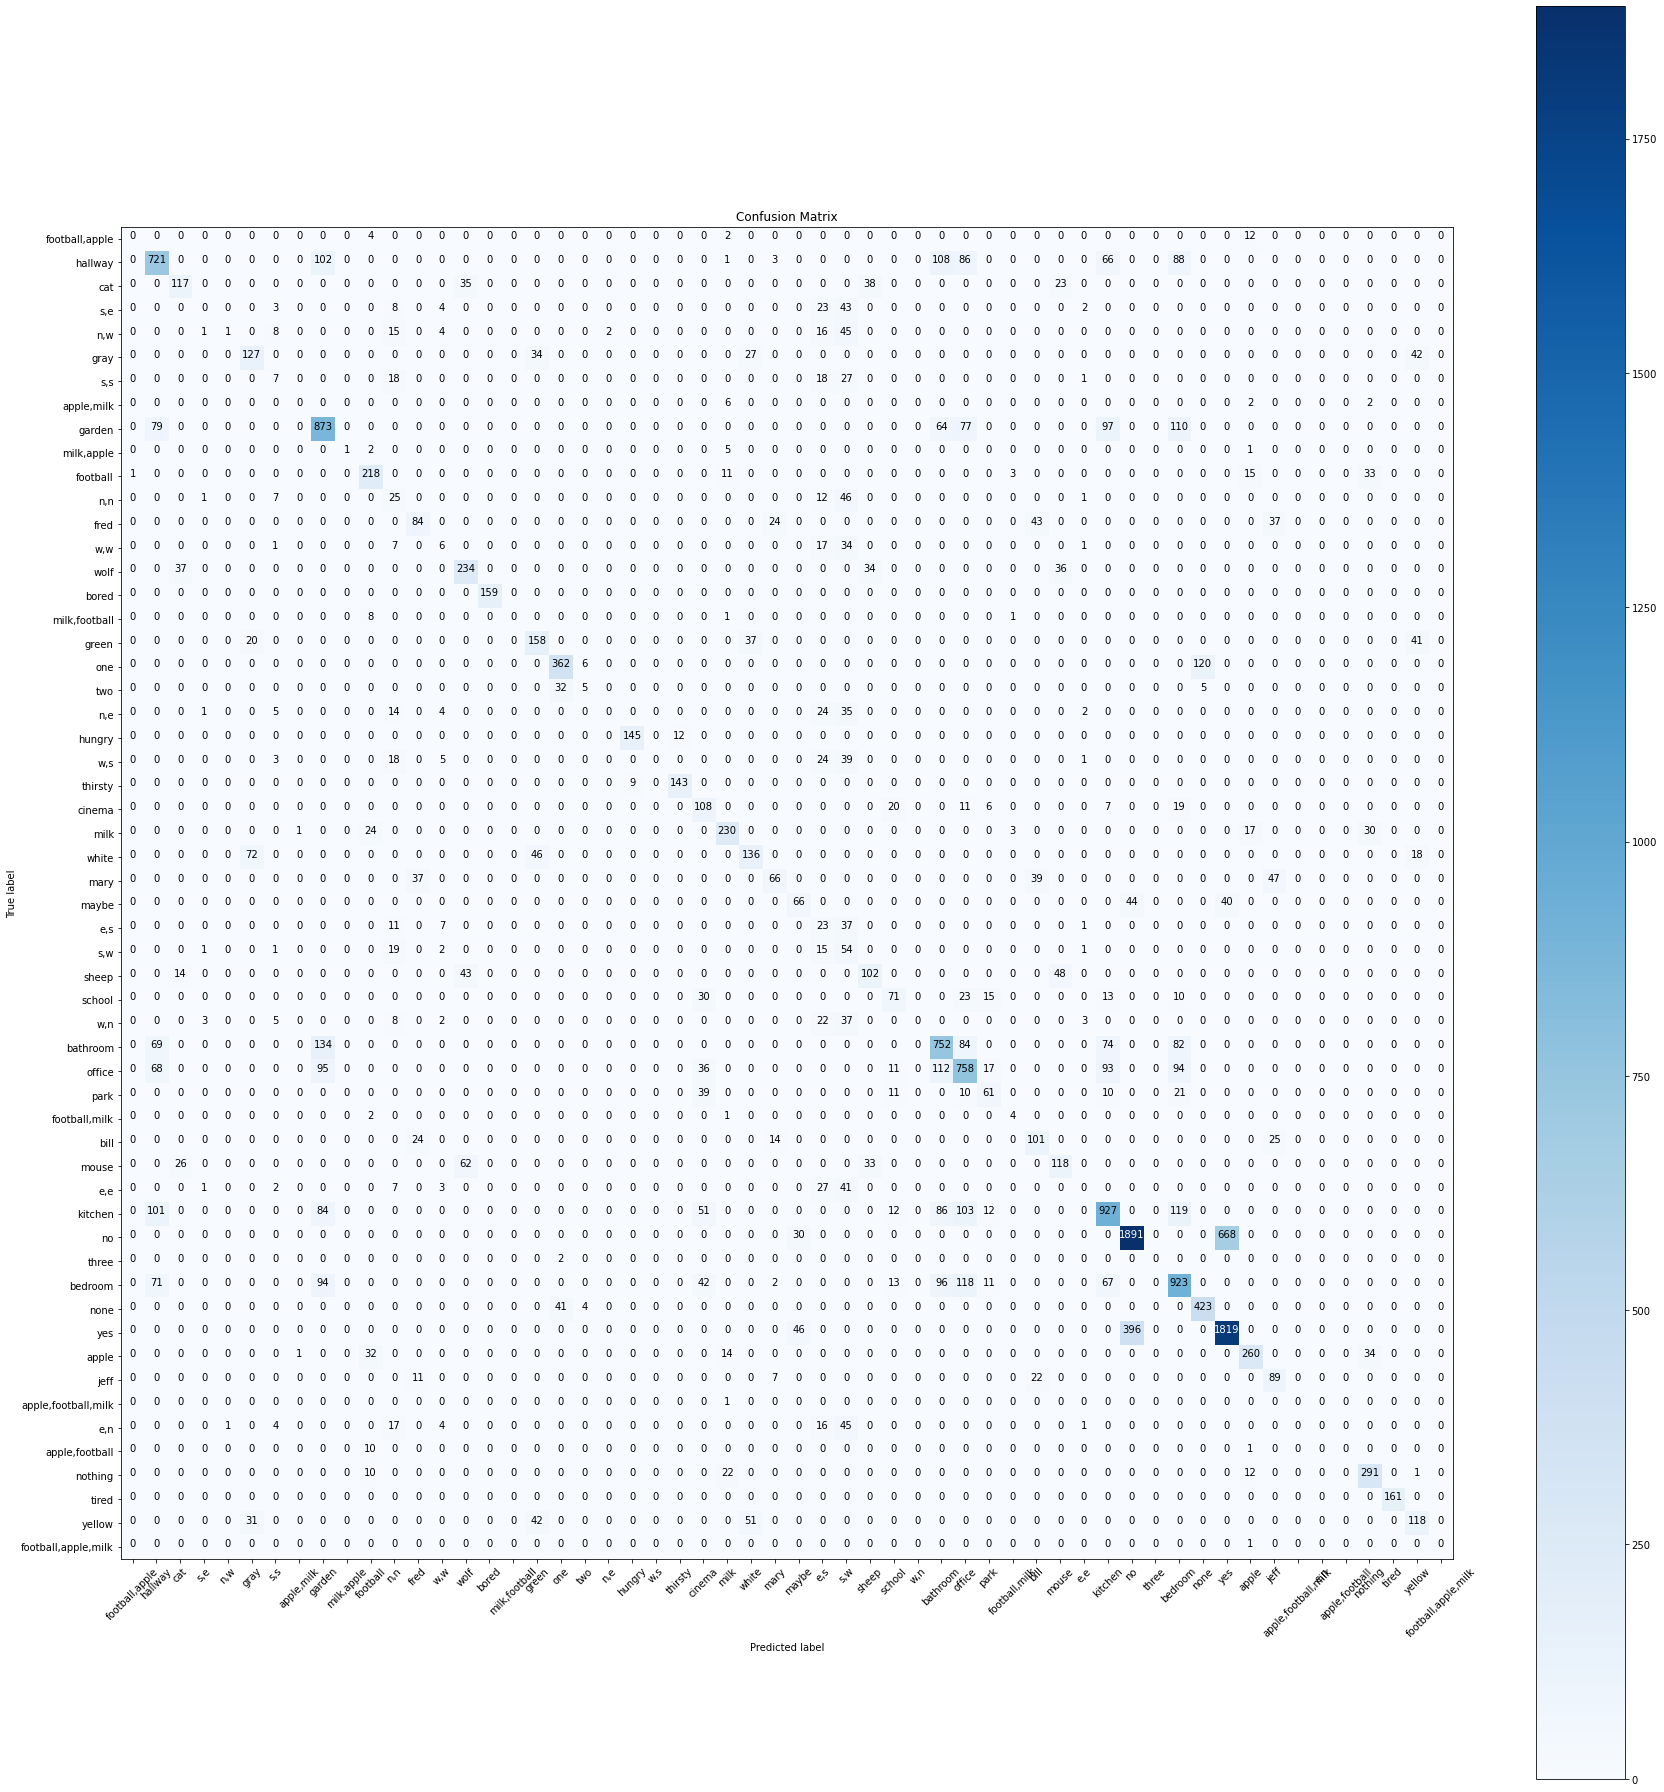

10.084796667098999


In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
checkpoint_name = f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
)

y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)

        logits = torch.squeeze(model(torch.cat((contexts, questions), 1))).cpu()
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(logits)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[int(i)] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[int(i)] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [ ]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

In [ ]:
# model.layers.append(model.layers[1])
print(len(model.layers))